In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

# Compare Everything.

I will compare all of the methods which I have created so far, this wont be the easiest as i have to compare them 1v1. There is prob a better way of doing this but this will suffice for the time being.

Methods to compare:
- ACI
- DtACI
- AwACI
- DtAwACI
- MACI
- HACIonesided
- HACIdual_tail
- HACIlastone

I have a bad feeling that ACI will perform the best.

In [2]:
acp = AdaptiveCP(0.1, 250)

In [3]:

method_dict = {
    'ACI': [AdaptiveCP.ACI, [0.005, None, None, 500], 0], 
    'DtACI': [AdaptiveCP.DtACI, [None, None, None, 500], 0],
    'AwACI': [AdaptiveCP.AwACI, [[*range(100, 600, 100 )], (10**-3, 0.05), 0.005], 0],
    'AwDtACI': [AdaptiveCP.AwDtACI, [[*range(100, 600, 100 )], (10**-3, 0.05), 0.005], 0],
    'MACI': [AdaptiveCP.MACI, [[*range(100, 600, 100 )], 3, 1, 200, (3*(10**-4), 0.15), 0.005], 0],
    'HACI_dual_tail': [AdaptiveCP.HACI_dual_tail, [0.005, None, None, 500], 1],
    'HACI_one_side': [AdaptiveCP.HACI_one_side, [0.005, None, None, 500], 1],
    'HACI': [AdaptiveCP.HACI, [0.005, None, None, 500], 1],
}

In [4]:
import pickle

def compute_everything(mdict, datapoints):
    completion_dict = {}

    for key, method in mdict.items():
        print(f'{key} start')

        method_result = ACP_data.test_on_stock_data(acp, method[0], datapoints, method[2], *method[1])
        print(f'{key} done')
        completion_dict[key] = method_result

    # dump the compeltion dict
    with open(f'completion_dict{datapoints}.pickle', 'wb') as handle:
        pickle.dump(completion_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return completion_dict


In [25]:
# We will now use multiprocessing to improve the compute_everything function. 
import multiprocessing

# process parameter: this is the number of processes that will be created at once, 
# Well im thinking we will likley have 20 process total, but if we run all at once then it will be slower. 
# So we will run 5 at a time, and then wait for them to finish. but one should start when one stops. 

# The greater improvment will probably come from the ACP_data class, do this first.

def compute_everything(mdict, datapoints):
    completion_dict = {}

    for key, method in mdict.items():
        print(f'{key} start')

        method_result = ACP_data.test_on_stock_data(acp, method[0], datapoints, method[2], *method[1])
        print(f'{key} done')
        completion_dict[key] = method_result

    # dump the compeltion dict
    with open(f'completion_dict{datapoints}.pickle', 'wb') as handle:
        pickle.dump(completion_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return completion_dict

def compute_everything_multiprocessing(mdict, datapoints, process_parameter):
    completion_dict = {}

    # create the pool
    pool = multiprocessing.Pool(process_parameter)
    
    # create the jobs
    jobs = []
    for key, method in mdict.items():
        job = pool.apply(ACP_data.test_on_stock_data, args=(acp, method[0], datapoints, method[2], *method[1]))
        jobs.append(job)
    
    # get the results
    for job, (key, _) in zip(jobs, mdict.items()):
        print(f'{key} start')
        completion_dict[key] = job.get()
        print(f'{key} done')
    
    # dump the compeltion dict
    with open(f'completion_dict{datapoints}.pickle', 'wb') as handle:
        pickle.dump(completion_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return completion_dict
    



In [21]:
import multiprocessing

def parallel_test_on_stock_data(ACP_instance, ACP_method, datapoints: int, withvar: bool = False, *args):
    '''Run method on multiple stock distributions and then return dictionary of results.'''
    
    raw_results = []
    
    stock_data = ACP_data.stock_data(datapoints)
    
    if withvar:
        stock_data = ACP_data.xvy_from_ACP(stock_data)
    else:
        stock_data = ACP_data.xvy_correction(stock_data)
    
    # create a list of tasks. 
    num_processes = 4

    for data_chunk_i in range(0, len(stock_data), num_processes):
        data_chunk = stock_data[data_chunk_i:data_chunk_i+num_processes]
        with multiprocessing.Pool(processes=num_processes) as pool:
            results = pool.starmap(ACP_method, [(ACP_instance, data, *args) for data in data_chunk])
            raw_results.extend(results)

    coverage_mean = np.mean([result['realised_interval_coverage'] for result in raw_results])
    width_mean = np.mean([result['average_prediction_interval'] for result in raw_results])

    results_dict = {
        'coverage_mean': coverage_mean,
        'width_mean': width_mean,
        'raw_results': raw_results
    }
    
    return results_dict

In [22]:
import time

method = method_dict['ACI']

start_time = time.time()
result2 = ACP_data.test_on_stock_data(acp, method[0], 50, method[2], *method[1])
end_time = time.time()
print(f"Sequential test execution time: {end_time - start_time} seconds")

start_time = time.time()
result1 = parallel_test_on_stock_data(acp, method[0], 50, method[2], *method[1])
end_time = time.time()
print(f"Parallel test execution time: {end_time - start_time} seconds")


result1, result2

Sequential test execution time: 21.773587942123413 seconds


KeyboardInterrupt: 

I think that for the test on stock_data, threading will be more useful as the load for each process is quite low so you wont be able to justify the overhead. But for the compare everything I think that multiprocessing will be a lot faster you shoudl experiment with implementing both the above.

Alternativley you could chunk together the runs but that isnt as easy as you think.

In [28]:
import time

start_time = time.time()
b = compute_everything_multiprocessing(method_dict, 5, 4)
end_time = time.time()
print(f"Multiprocessing execution time: {end_time - start_time} seconds")

start_time = time.time()
c = compute_everything(method_dict, 5)
end_time = time.time()
print(f"Sequential execution time: {end_time - start_time} seconds")



ACI start


TypeError: get expected at least 1 argument, got 0

In [ ]:
a = compute_everything(method_dict, 25)

ACI start


KeyboardInterrupt: 

In [ ]:
raw_results = pickle.load(open('completion_dict25.pickle', 'rb'))

NameError: name 'pickle' is not defined

In [ ]:
from pprint import pprint
pprint(a['ACI'].keys())

dict_keys(['coverge', 'width', 'raw_results', 'coverage_mean', 'width_mean'])


In [ ]:
pprint(ACP_data.simple_comparison(a['ACI']['raw_results'], a['HACI_one_side']['raw_results'])[0])

{'average_coverage_difference_mean': np.float64(-0.0004169412628937108),
 'better_coverage_mean': np.float64(0.32),
 'largest_coverage_deviation_mean': np.float64(0.12),
 'largest_ratio_above_and_below_deviation_mean': np.float64(0.52),
 'relative_width_mean': np.float64(0.9935689939563097),
 'relative_width_no_outliers_mean': np.float64(0.9935689939563097),
 'relative_width_std': np.float64(0.03659144534419432)}


In [ ]:
# We will now compare every method against the ACI method and plot each result.
methods_to_compare = ['DtACI', 'AwACI', 'AwDtACI', 'MACI', 'HACI_dual_tail', 'HACI_one_side', 'HACI']
comparison_dict = {method: ACP_data.simple_comparison(a['ACI']['raw_results'], a[method]['raw_results'])[0] for method in methods_to_compare}

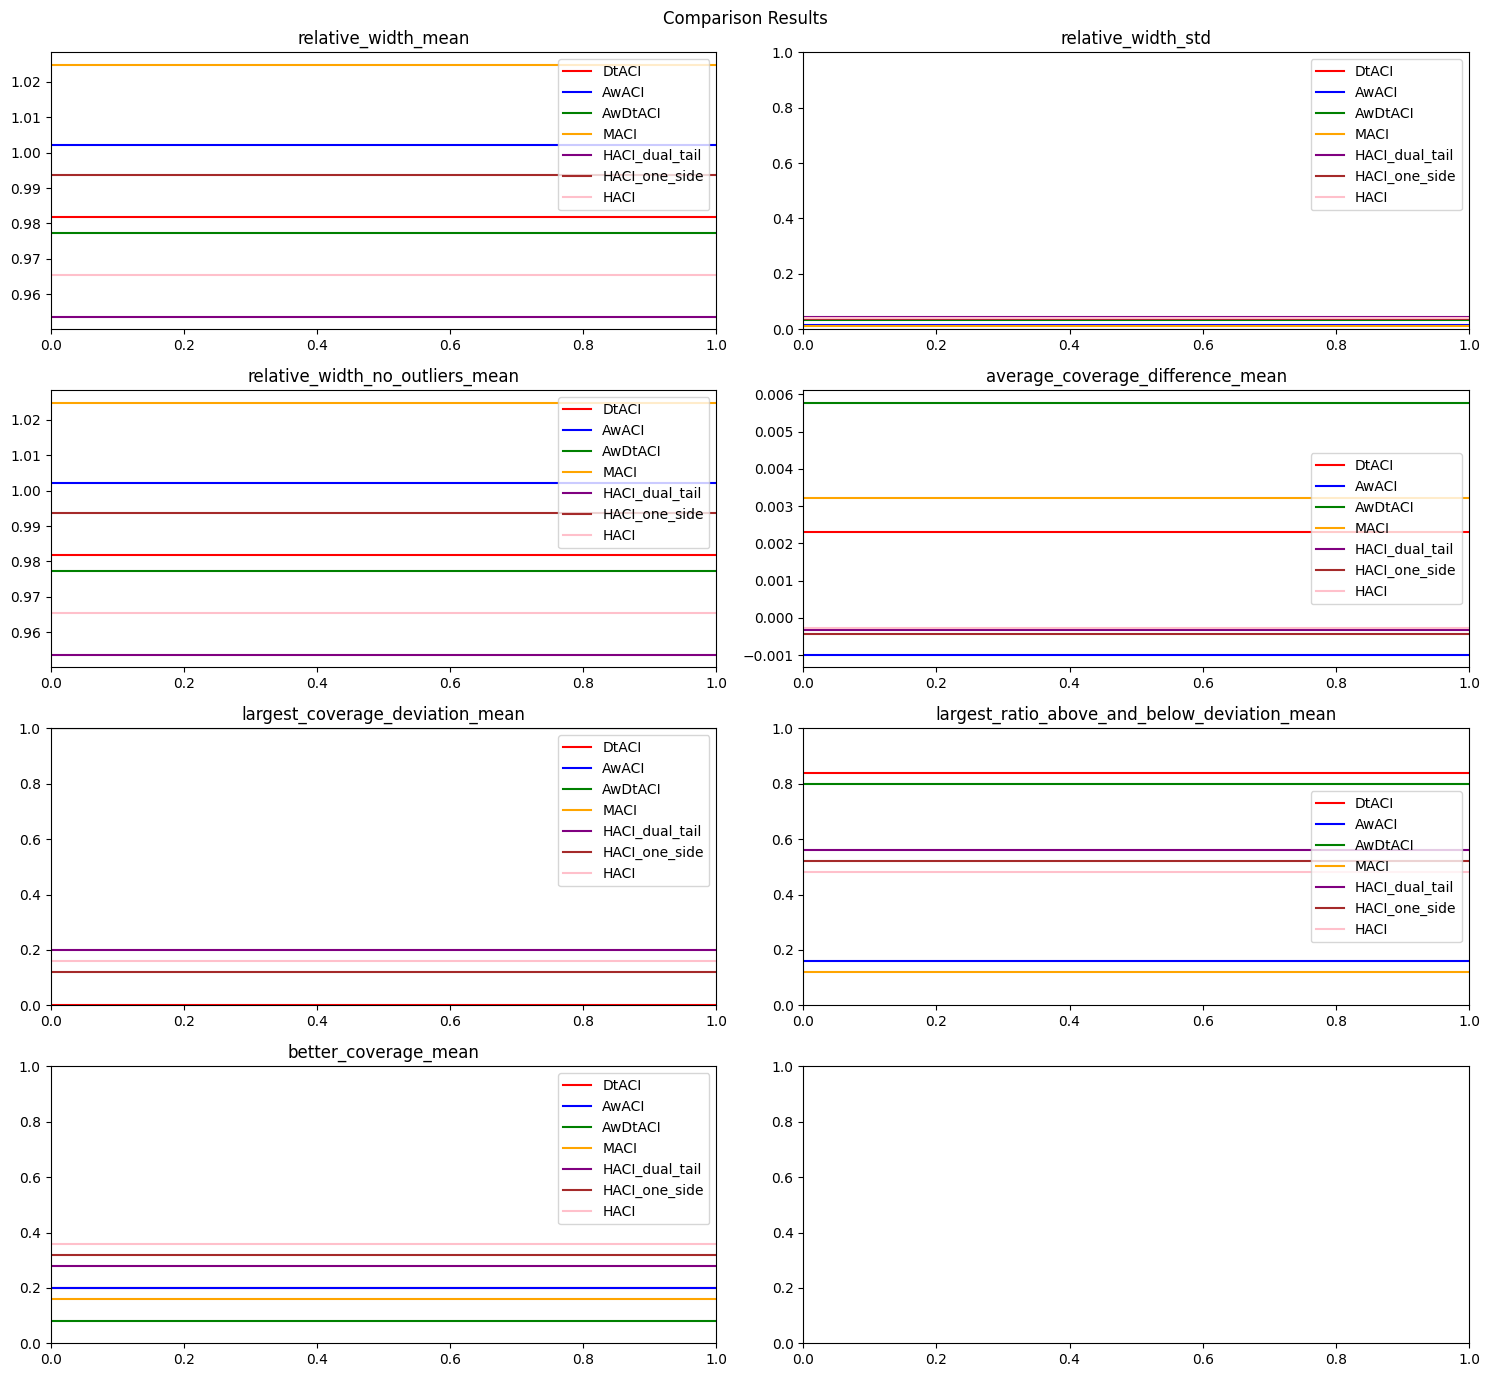

In [ ]:
comparitors = len(comparison_dict['DtACI'])

fig, axs = plt.subplots(comparitors//2 + 1, 2, figsize=(15, 2 * comparitors))
fig.suptitle('Comparison Results')

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']  # Add more colors if needed

for j, (method, comparison) in enumerate(comparison_dict.items()):
    for i, (key, value) in enumerate(comparison.items(), start=0):
        axs[i//2, i%2].axhline(value, label=method, color=colors[j])  # Use different colors for each method
        if j == 0:
            axs[i//2, i%2].set_title(key)
        axs[i//2, i%2].legend()

plt.tight_layout()  # Increase spacing between the plots
plt.show()


In [ ]:
pprint(comparison_dict['HACI'])

{'average_coverage_difference_mean': np.float64(-0.000268011141379203),
 'better_coverage_mean': np.float64(0.36),
 'largest_coverage_deviation_mean': np.float64(0.16),
 'largest_ratio_above_and_below_deviation_mean': np.float64(0.48),
 'relative_width_mean': np.float64(0.9655399159082179),
 'relative_width_no_outliers_mean': np.float64(0.9655399159082179),
 'relative_width_std': np.float64(0.03894267210760373)}


In [ ]:
def compare_against(method, given_raw_results):
    methods_to_compare = ['ACI','DtACI', 'AwACI', 'AwDtACI', 'MACI', 'HACI_dual_tail', 'HACI_one_side', 'HACI']
    comparitors = len(methods_to_compare) - 1
    
    assert method in methods_to_compare, f'{method} not in {methods_to_compare}'

    methods_to_compare.remove(method)

    comparison_dict = {compare_method: ACP_data.simple_comparison(given_raw_results[method]['raw_results'], given_raw_results[compare_method]['raw_results'])[0] for compare_method in methods_to_compare}

    fig, axs = plt.subplots(comparitors//2 + 1, 2, figsize=(15, 2 * comparitors))
    fig.suptitle(f'Comparison Results when comparing against {method}')

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']  # Add more colors if needed

    for j, (method, comparison) in enumerate(comparison_dict.items()):
        for i, (key, value) in enumerate(comparison.items(), start=0):
            axs[i//2, i%2].axhline(value, label=method, color=colors[j])  # Use different colors for each method
            if j == 0:
                axs[i//2, i%2].set_title(key)
            axs[i//2, i%2].legend()

    plt.tight_layout()  # Increase spacing between the plots
    plt.show()

In [ ]:
compare_against('ACI', raw_results)

NameError: name 'raw_results' is not defined